In [1]:
# Modify the file 00_setup.py to define input/output file paths on your system
# The information in 00_setup.py will be used across notebooks
from importlib.machinery import SourceFileLoader
setup = SourceFileLoader("setup", "./00_setup.py").load_module()

# Low Volume NAICS performance
Look at the model performance vs. # of businesses per NAICS.  Examine NAICS codes present in the training and test data only.  Bucket NAICS by volume, and look at test dataset performance for businesses corresponding to the buckets. 

Also combine all metrics for easy comparisons

*This script takes about 5 minutes on my MacBook Air*

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from pathlib import Path

In [4]:
from sba_gnn.sba_gnn import sg_plot 

In [5]:
sg_plot.plot_defaults()

## File Dictionaries

##### Raw predictions - will get metrics for low volume naics

In [6]:
dict_pred = {'xgb base': Path(setup.temp_path).joinpath('03_DATA_combined_predictions.parquet'),
              'xgb mean':  Path(setup.temp_path).joinpath('04_DATA_combined_predictions.parquet'),
              'xgb one hot':  Path(setup.temp_path).joinpath('05_DATA_combined_predictions.parquet'),
              'xgb numeric naics':  Path(setup.temp_path).joinpath('06_DATA_combined_predictions.parquet'),
              'xgb mean+count enc':  Path(setup.temp_path).joinpath('07_DATA_combined_predictions.parquet'),
              'xgb grp mean':  Path(setup.temp_path).joinpath('08_DATA_combined_predictions.parquet'),
              'xgb mean alt+count enc':  Path(setup.temp_path).joinpath('09_DATA_combined_predictions.parquet'),
              'nn baseline': Path(setup.temp_path).joinpath('11_DATA_predictions.parquet'),
              'nn emb': Path(setup.temp_path).joinpath('12_DATA_predictions.parquet'),
              'nn numeric naics': Path(setup.temp_path).joinpath('13_DATA_predictions.parquet'),
              'nn one hot': Path(setup.temp_path).joinpath('14_DATA_predictions.parquet'),
              'nn emb+count enc': Path(setup.temp_path).joinpath('15_DATA_predictions.parquet'),
              'nn emb remap': Path(setup.temp_path).joinpath('16_DATA_predictions.parquet'),
              'gnn': Path(setup.temp_path).joinpath('22_DATA_predictions_all.parquet'),
              'gnn+count enc': Path(setup.temp_path).joinpath('25_DATA_predictions_all.parquet'),
              'xgb emb nn': Path(setup.temp_path).joinpath('40_DATA_combined_predictions.parquet'),
              'xgb emb nn+count enc': Path(setup.temp_path).joinpath('41_DATA_combined_predictions.parquet'),
              'xgb emb nn remap': Path(setup.temp_path).joinpath('42_DATA_combined_predictions.parquet'),
              'xgb emb nn remap+count enc': Path(setup.temp_path).joinpath('43_DATA_combined_predictions.parquet'),
              'xgb dgi base': Path(setup.temp_path).joinpath('50_DATA_combined_predictions.parquet'),
              'xgb dgi base+count enc': Path(setup.temp_path).joinpath('51_DATA_combined_predictions.parquet'),
              'xgb dgi base+label': Path(setup.temp_path).joinpath('52_DATA_combined_predictions.parquet'),
              'xgb dgi nnfeat': Path(setup.temp_path).joinpath('53_DATA_combined_predictions.parquet'),
              'xgb dgi nnfeat+label': Path(setup.temp_path).joinpath('54_DATA_combined_predictions.parquet')
            }

In [7]:
# Verify these all exist
all([Path(v).exists() for k, v in dict_pred.items()])

True

In [8]:
#{k:Path(v).exists() for k, v in dict_pred.items()}

##### Standard metrics
Get filenames for standard metrics calculated in all scripts. These all have similar file naming

In [9]:
dict_metrics = {k:Path(setup.temp_path).joinpath(v.name[0:2] + '_REPORT_metrics.csv') \
                for k, v in dict_pred.items()}

In [10]:
# Verify these all exist
all([Path(v).exists() for k, v in dict_metrics.items()])

True

## Combine standard metrics

In [11]:
all_metrics = pd.concat([pd.read_csv(v) for k, v in dict_metrics.items()],
                        keys = dict_metrics.keys()) \
    .reset_index(level=0) \
    .drop(columns=['Unnamed: 0'], errors='ignore') \
    .rename(columns={'level_0':'model'})

In [12]:
all_metrics[(all_metrics['dset'] == 'test') & (all_metrics['dset_naics_holdout'] == 0)] \
    .sort_values('average_precision_score', ascending=False)

,model,dset,accuracy_score,f1_score,precision_score,recall_score,average_precision_score,roc_auc_score,dset_naics_holdout
3,xgb emb nn,test,0.665784,0.452451,0.339549,0.677837,0.394202,0.734922,0.0
3,xgb emb nn+count enc,test,0.665522,0.451839,0.339146,0.676695,0.392932,0.734679,0.0
3,xgb emb nn remap+count enc,test,0.665988,0.451940,0.339428,0.676028,0.391982,0.734309,0.0
3,xgb emb nn remap,test,0.665726,0.451903,0.339278,0.676457,0.391694,0.734130,0.0
3,xgb mean+count enc,test,0.666424,0.451373,0.339401,0.673601,0.391575,0.732893,0.0
3,xgb grp mean,test,0.666124,0.451150,0.339149,0.673601,0.391080,0.732733,0.0
3,xgb mean alt+count enc,test,0.666415,0.451366,0.339393,0.673601,0.391046,0.732518,0.0
3,xgb mean,test,0.666201,0.451190,0.339207,0.673553,0.390945,0.732716,0.0
3,nn emb+count enc,test,0.670662,0.450783,0.341358,0.663462,0.389118,0.732971,0.0
3,nn emb,test,0.660141,0.450865,0.336043,0.684882,0.388653,0.732290,0.0


In [13]:
all_metrics[(all_metrics['dset'] == 'test') & (all_metrics['dset_naics_holdout'] == 1)] \
    .sort_values('f1_score', ascending=False)

,model,dset,accuracy_score,f1_score,precision_score,recall_score,average_precision_score,roc_auc_score,dset_naics_holdout
4,xgb numeric naics,test,0.678191,0.429051,0.324135,0.634388,0.362891,0.729245,1.0
4,xgb dgi base+label,test,0.655142,0.427597,0.312737,0.675799,0.354919,0.725719,1.0
4,xgb dgi nnfeat,test,0.653672,0.426840,0.311761,0.676586,0.344679,0.721780,1.0
4,xgb dgi base+count enc,test,0.682573,0.425881,0.324967,0.617698,0.351960,0.724432,1.0
4,xgb one hot,test,0.633594,0.425756,0.303555,0.712644,0.353897,0.722105,1.0
4,nn baseline,test,0.614267,0.425718,0.297193,0.750118,0.348599,0.718693,1.0
4,xgb base,test,0.626182,0.424931,0.300607,0.724610,0.355814,0.723045,1.0
4,nn one hot,test,0.622520,0.421648,0.297785,0.721934,0.345082,0.716660,1.0
4,xgb dgi base,test,0.669518,0.421335,0.316192,0.631239,0.349985,0.722550,1.0
4,xgb mean,test,0.648480,0.421037,0.306844,0.670603,0.351686,0.720934,1.0


In [14]:
all_metrics.to_csv(Path(setup.temp_path).joinpath('60_REPORT_metrics_combined.csv'), index=False)

## Examine Low Volume, Non-Holdout NAICS
Do the poorer results for "holdout" NAICS also occur for infrequent NAICS?

##### Import loans data to label NAICS as low volume

In [15]:
sba_loans = pd.read_parquet(Path(setup.temp_path).joinpath('01_DATA_transformed.parquet'))

In [16]:
train_df = sba_loans[sba_loans['dset'] == 'train']
test_df = sba_loans[sba_loans['dset'] == 'test']
val_df = sba_loans[sba_loans['dset'] == 'val']

#### NAICS volume and selection
Find NAICS in the training data and get # of associated businesses.  

In [17]:
naics_train_info = sba_loans[sba_loans['dset'] == 'train'][['NAICS']].value_counts().reset_index()

In [18]:
naics_train_info['count'].sum()

425594

In [19]:
naics_train_info['naics_count_grp'] = pd.cut(naics_train_info['count'], [1, 50, 500, np.Inf],
                                           include_lowest=True)

In [20]:
naics_train_info.groupby('naics_count_grp')['count'].agg(['min', 'max', 'mean', 'count', 'sum'])

,min,max,mean,count,sum
naics_count_grp,,,,,
"(0.999, 50.0]",1,50,18.422594,478,8806
"(50.0, 500.0]",51,486,174.461672,574,100141
"(500.0, inf]",501,18218,1759.150000,180,316647


##### Codes also in test

In [21]:
naics_train_info = naics_train_info.merge(sba_loans[sba_loans['dset'] == 'test'][['NAICS']].drop_duplicates(),
                                          on='NAICS')

In [22]:
naics_train_info.groupby('naics_count_grp')['count'].agg(['min', 'max', 'mean', 'count', 'sum'])

,min,max,mean,count,sum
naics_count_grp,,,,,
"(0.999, 50.0]",1,50,21.299252,401,8541
"(50.0, 500.0]",51,486,174.461672,574,100141
"(500.0, inf]",501,18218,1759.150000,180,316647


In [23]:
naics_train_info

,NAICS,count,naics_count_grp
0,722110,18218,"(500.0, inf]"
1,722211,12712,"(500.0, inf]"
2,811111,9264,"(500.0, inf]"
3,621210,8997,"(500.0, inf]"
4,624410,6432,"(500.0, inf]"
...,...,...,...
1150,926120,1,"(0.999, 50.0]"
1151,922150,1,"(0.999, 50.0]"
1152,315992,1,"(0.999, 50.0]"
1153,212399,1,"(0.999, 50.0]"


In [24]:
naics_train_info.to_csv(Path(setup.temp_path).joinpath('60_REPORT_naics_train_counts.csv'), index=False)

### Metrics By NAICS Volume

##### Function to take in a predictions file and get all metrics

In [25]:
def pred_metrics(filename, 
                 naics_map = sba_loans[['NAICS', 'LoanNr_ChkDgt']],
                naics_counts = naics_train_info[['NAICS', 'naics_count_grp']]):
    """ Open file, merge NAICS counts, and get metrics by NAICS count"""
    pred_df = pd.read_parquet(filename) \
        [['LoanNr_ChkDgt', 'predict_prob', 'predict_bin', 'target', 'dset']]
    
    pred_sel = pred_df[pred_df['dset'] == 'test'] \
        .merge(naics_map[['NAICS', 'LoanNr_ChkDgt']], on='LoanNr_ChkDgt') \
        .merge(naics_counts[['NAICS', 'naics_count_grp']], on='NAICS')

    return pred_sel.groupby('naics_count_grp') \
        .apply(lambda x: sg_plot.dset_metrics(x.target, x.predict_bin, x.predict_prob)) \
        .reset_index()

##### Apply function to many models
Summarize by count group

In [26]:
metrics_naics_vol = pd.concat([pred_metrics(v) for k, v in dict_pred.items()],
                         keys = dict_pred.keys()) \
    .reset_index(level=0) \
    .rename(columns={'level_0':'model'})

In [27]:
metrics_naics_vol['dset'] = 'test'

In [28]:
metrics_naics_vol.to_csv(Path(setup.temp_path).joinpath('60_REPORT_metrics_by_naics_volume.csv'),
                    index=False)

In [29]:
metrics_naics_vol[metrics_naics_vol['naics_count_grp'].astype('str') == '(0.999, 50.0]'] \
    .sort_values('f1_score', ascending=False).head(5)

,model,naics_count_grp,accuracy_score,f1_score,precision_score,recall_score,average_precision_score,roc_auc_score,dset
0,xgb numeric naics,"(0.999, 50.0]",0.739852,0.470693,0.367036,0.655941,0.385771,0.770224,test
0,xgb one hot,"(0.999, 50.0]",0.707115,0.451349,0.336996,0.683168,0.365987,0.757162,test
0,xgb mean alt+count enc,"(0.999, 50.0]",0.773898,0.451271,0.394444,0.527228,0.377639,0.737719,test
0,nn one hot,"(0.999, 50.0]",0.697512,0.450436,0.331389,0.702970,0.349172,0.753004,test
0,xgb dgi nnfeat,"(0.999, 50.0]",0.748581,0.450382,0.366460,0.584158,0.373522,0.768142,test


## Summary Data
For test dataset only, show AUC and f1 scores for test dataset, along with f1 scores for holdout and low-volume NAICS

In [30]:
overall_stats =  all_metrics[(all_metrics['dset'] == 'test') & \
                             (all_metrics['dset_naics_holdout'] == 0)] \
    [['model', 'roc_auc_score', 'average_precision_score', 'f1_score']]

In [31]:
holdout_stats = all_metrics[(all_metrics['dset'] == 'test') & \
                            (all_metrics['dset_naics_holdout'] == 1)] \
    [['model', 'f1_score']] \
    .rename(columns={'f1_score':'f1_score_ho'})

In [32]:
low_vol_stats = metrics_naics_vol[metrics_naics_vol['naics_count_grp'].astype('str') == '(0.999, 50.0]'] \
     [['model', 'f1_score']] \
    .rename(columns={'f1_score':'f1_score_low_vol'})   

In [33]:
overall_stats = overall_stats.merge(holdout_stats, on='model') \
    .merge(low_vol_stats, on='model')

##### Type information

In [34]:
cond = [overall_stats['model'].str.startswith('xgb emb'),
        overall_stats['model'].str.startswith('xgb dgi'),
        overall_stats['model'].str.startswith('xgb'),
       overall_stats['model'].str.startswith('gnn')]
choice = ['xgb emb nn', 'xgb dgi', 'xgb', 'gnn']
overall_stats['type'] = np.select(cond, choice, 'nn')   

In [35]:
overall_stats['model_base'] = overall_stats['model'].str.split('+count', regex=False).apply(lambda x: x[0])
overall_stats['count_enc'] = np.where(overall_stats['model'].str.contains('+count', regex=False), 1, 0)

In [36]:
overall_stats.sort_values('average_precision_score', ascending=False)

,model,roc_auc_score,average_precision_score,f1_score,f1_score_ho,f1_score_low_vol,type,model_base,count_enc
15,xgb emb nn,0.734922,0.394202,0.452451,0.411568,0.432319,xgb emb nn,xgb emb nn,0
16,xgb emb nn+count enc,0.734679,0.392932,0.451839,0.401964,0.432323,xgb emb nn,xgb emb nn,1
18,xgb emb nn remap+count enc,0.734309,0.391982,0.451940,0.307184,0.443077,xgb emb nn,xgb emb nn remap,1
17,xgb emb nn remap,0.734130,0.391694,0.451903,0.309044,0.439628,xgb emb nn,xgb emb nn remap,0
4,xgb mean+count enc,0.732893,0.391575,0.451373,0.420978,0.449842,xgb,xgb mean,1
5,xgb grp mean,0.732733,0.391080,0.451150,0.410539,0.445148,xgb,xgb grp mean,0
6,xgb mean alt+count enc,0.732518,0.391046,0.451366,0.387619,0.451271,xgb,xgb mean alt,1
1,xgb mean,0.732716,0.390945,0.451190,0.421037,0.447479,xgb,xgb mean,0
11,nn emb+count enc,0.732971,0.389118,0.450783,0.409165,0.433476,nn,nn emb,1
8,nn emb,0.732290,0.388653,0.450865,0.406653,0.433161,nn,nn emb,0


In [37]:
overall_stats.to_csv(Path(setup.temp_path).joinpath('60_REPORT_summary_stats.csv'),
                    index=False)

<Axes: xlabel='roc_auc_score', ylabel='average_precision_score'>

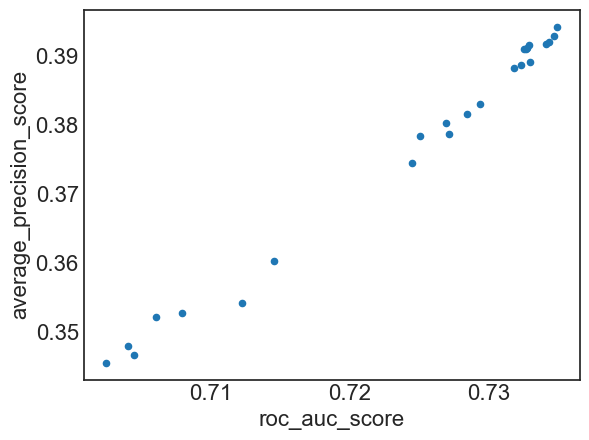

In [38]:
overall_stats.plot(x='roc_auc_score', y='average_precision_score',  kind='scatter')

<Axes: xlabel='f1_score_low_vol', ylabel='f1_score_ho'>

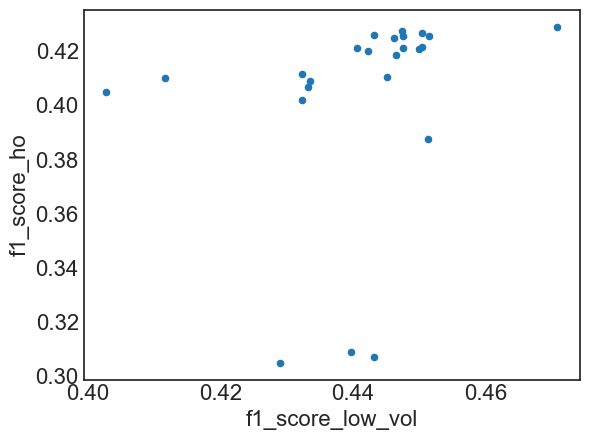

In [39]:
overall_stats.plot(x='f1_score_low_vol', y='f1_score_ho',  kind='scatter')
#plt.gca().axline((0.4, 0.4), slope=1)

<Axes: xlabel='f1_score', ylabel='f1_score_low_vol'>

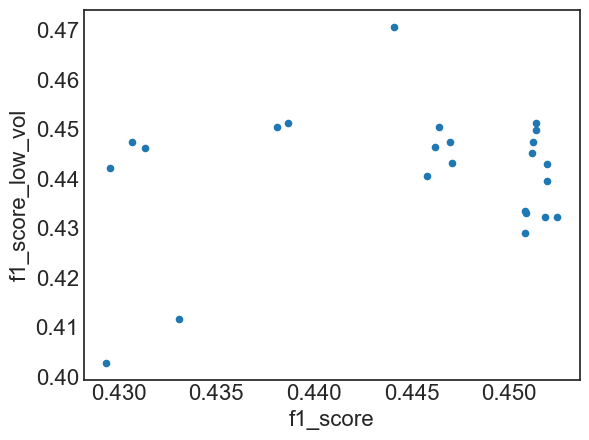

In [40]:
overall_stats.plot(x='f1_score', y='f1_score_low_vol',  kind='scatter')
#plt.gca().axline((0.41, 0.41), slope=1)

<Axes: xlabel='f1_score', ylabel='f1_score_ho'>

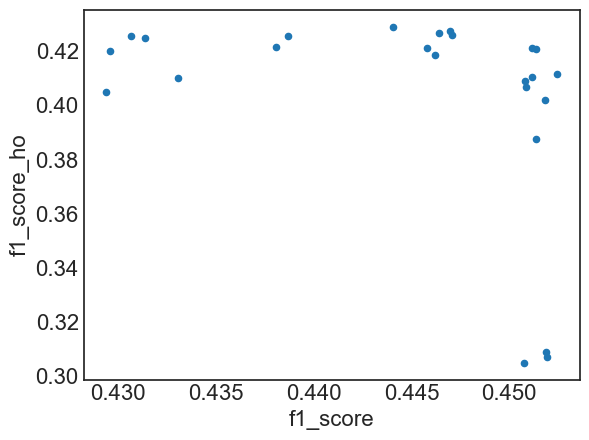

In [41]:
overall_stats.plot(x='f1_score', y='f1_score_ho',  kind='scatter')
#plt.gca().axline((0.4, 0.4), slope=1)

## Color Code f1
Or otherwise show info

## Plot selected metrics

In [42]:
overall_perf = 0.44

In [43]:
sg_plot.plot_defaults()
#plt.style.use('fast')

In [44]:
#model_list = ['xgb baseline', 'nn baseline', 'nn embed NAICS', 'gnn']
#model_list = ['xgb baseline', 'xgb mean encoding', 'xgb numeric NAICS', 'nn baseline', 'nn embed NAICS',
#             'xgb + nn embed', 'xgb + dgi embed', 'xgb + dgi embed, label']
model_list = dict_pred.keys()

In [45]:
metric = 'f1_score'

In [46]:
#[metrics_comb['model'].isin(model_list)] \
metrics_comb['model'] = pd.Categorical(metrics_comb['model'], categories = model_list)
plot_df = metrics_comb \
    [['count_grp', metric, 'model']] \
    .pivot(index='count_grp', columns='model', values=metric)

NameError: name 'metrics_comb' is not defined

In [ ]:
plot_df['xgb baseline']

In [ ]:
ax = sns.heatmap(plot_df.transpose(), linewidth=0.5, cmap="PuOr")
plt.show()
plt.gcf().savefig(Path(setup.temp_path).joinpath('60_PLOT_perf_by_naics_count.png'),
                  bbox_inches='tight')

In [ ]:
TO DO
6X, 7X check headings
Rerun some of 6X, 7X (later ones)
Fix 80 titles / markdown
Add count encodings to mean encodings 6X,7X